<center>

# **Analyse de la Danse de l'Égyptien**
</center>

### I. INSTALLATION ET UTILISATION DE LA LIBRAIRIE

Afin de garantir la fiabilité de nos futures analyses de trajectoires, nous mettons en place un test avec l'outil MMPoseInferencer. L'objectif est de vérifier la fiabilité de la lecture et la visualisation des données.

Nous ciblons ici l'extraction des articulations standards (épaules, coudes, poignets) qui seront les variables importante pour la suite de notre projet.

In [1]:
import torch
print("Tu utilises :", "CUDA (Carte Graphique / GPU) 🚀" if torch.cuda.is_available() else "CPU (Processeur / Lent) 🐢")

Tu utilises : CPU (Processeur / Lent) 🐢


In [2]:
import mmengine
import mmcv
import mmdet
import mmpose
from mmpose.apis import MMPoseInferencer
import matplotlib.pyplot as plt
import os
import json
import numpy as np
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.optim as optim

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-m_simcc-body7_pt-body7_420e-256x192-e48f03d0_20230504.pth
01/17 13:47:19 - mmengine - WARNING - Failed to search registry with scope "mmpose" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmpose" is a correct scope, or whether the registry is initialized.
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
01/17 13:47:19 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a corre

/home/helena/miniconda3/envs/openmmlab/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


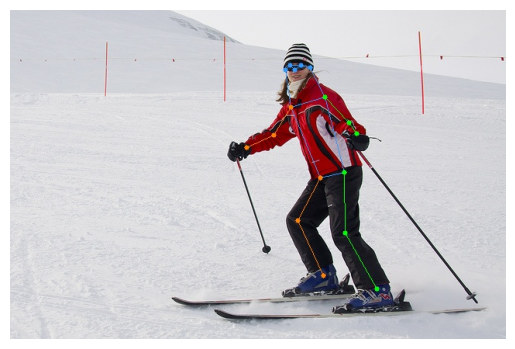

In [3]:
inferencer = MMPoseInferencer('human', device='cpu') 

image = 'demo.jpg'
result_generator = inferencer(image, vis=True, out_dir='vis_results')
result = next(result_generator)

vis_img_path = os.path.join('vis_results', 'visualizations', os.path.basename(image))
vis_img = mmcv.imread(vis_img_path)

plt.imshow(mmcv.bgr2rgb(vis_img))
plt.axis('off')
plt.show()

On remarque bien ici les articulations du corps avec les yeux, les oreilles et le nez. Nous pouvons donc passer à la suite du projet.

### II. PRÉSENTATION DES DONNÉES UTILISÉES

Nous avons choisi de travailler sur une vidéo du jeu Just Dance. Nous avons donc deux vidéos à analyser :
- La vidéo originale de la danse 
- Une vidéo de nous qui reproduisons cette même danse

Notre but est de comparer nos mouvements par rapport à la vidéo originale pour savoir qui de nous reproduit le mieux la danse.
Nous avons choisi un mouvement assez répétitif afin de pouvoir en tirer une prédiction sur les prochains mouvements.

Nous n'avons pas encore filmé la vidéo de nous qui dansons. Pour l'instant nous allons baser nos analyses sur la vidéo originale et nous rajouterons la semaine prochaine notre vidéo.

In [7]:
# Nous avons pris un extrait raw de just dance afin d'éviter le bruit sur la vidéo

HTML("""
<video width="600" controls>
  <source src="original.mp4" type="video/mp4">
</video>
""")

### PREMIERS RÉSULTATS

Utilisons MMPoseInferencer afin d'extraire les keypoints de nos vidéos.

In [22]:
original = 'original.mp4'

result_generator = inferencer(original, vis=True, out_dir='vis_results')

for frame_result in result_generator:
    pass

12/29 11:20:48 - mmengine - INFO - the output video has been saved at vis_results/visualizations/original.mp4


L'outil nous génère deux fichiers : 
- Un fichier vidéo mp4 qui reprend la vidéo de base en ajoutant les keypoints directement sur l'image
- Un fichier json qui contient toutes les coordonnées de chaque keypoints image par image et personne par personne

C'est sur ce dernier fichier json que nous allons pouvoir étudier les trajectoires et mouvements de nos personnages.

In [10]:
HTML(""" 
<video width="600" controls>
  <source src="vis_results/visualizations/original.mp4" type="video/mp4">
</video>
""")

### III. ANALYSE DES TRAJECTOIRES

Nous allons utiliser le fichier json pour extraire la positions des poignets du danseur frame par frame. Cependant, les coordonnées brutes extraites par MMPose sont exprimées en pixels. Nous ne pouvons donc pas travailler directement avec ces valeurs car :
- Un danseur proche de l'objectif aura des mouvements qui paraissent "plus grands" qu'un danseur au second plan.
- La taille des membres varie d'un individu à l'autre.

Pour l'instant cela ne pose pas de problème car nous avons qu'une seule vidéo à analyser mais quand nous ajouterons l'analyse de notre danse, nous aurons besoin de données normalisées.

Nous déplaçons donc l'origine du repère au milieu de la ligne des épaules. Ainsi, la position du poignet est mesurée relativement au buste et non au cadre de l'image.

La formule appliquée pour chaque frame est :

$$Y_{norm} = \frac{Y_{poignet} - Y_{milieu\_épaules}}{Distance(Épaule_{G}, Épaule_{D})}$$

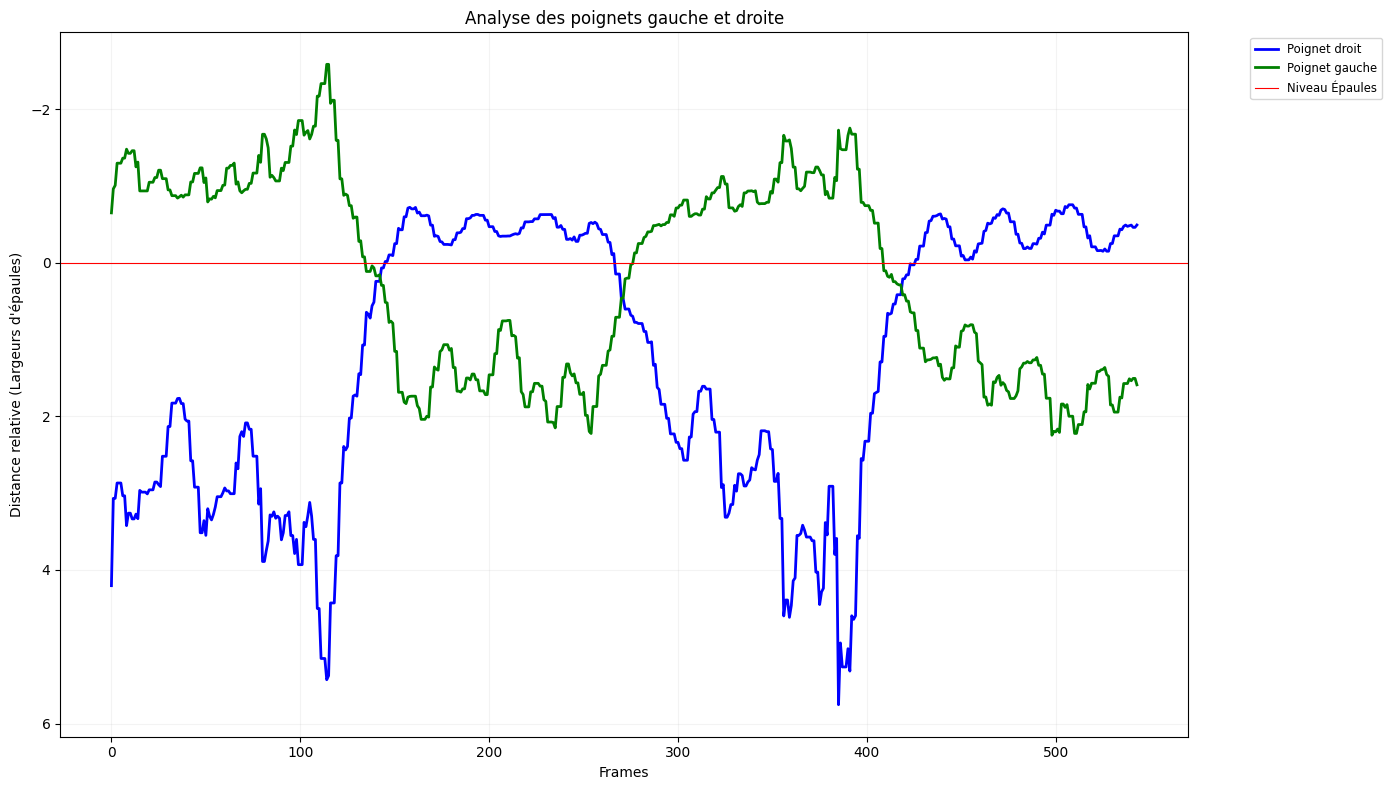

In [3]:
def trajectoires_normalisees(nom_fichier, nb_danseurs=1):
    with open(nom_fichier, 'r') as f:
        data = json.load(f)
    
    frames = []
    # On prépare des listes pour stocker les poignets droits et gauches
    traj_droit = [[] for _ in range(nb_danseurs)]
    traj_gauche = [[] for _ in range(nb_danseurs)]
    
    for f_data in data:
        frames.append(f_data['frame_id'])
        # Tri des personnes de gauche à droite pour ne pas mélanger les courbes
        insts = sorted(f_data['instances'], key=lambda x: np.mean([kp[0] for kp in x['keypoints']]))
        
        for i in range(nb_danseurs):
            if i < len(insts):
                keypoints = np.array(insts[i]['keypoints'])
                
                # 1. Calcul du milieu des épaules (référence 0)
                milieu_epaules = (keypoints[5][1] + keypoints[6][1]) / 2
                
                # 2. Calcul de la largeur des épaules (unité de normalisation)
                largeur_epaules = np.linalg.norm(np.array(keypoints[5][:2]) - np.array(keypoints[6][:2]))
                largeur_epaules = largeur_epaules if largeur_epaules > 0 else 1
                
                # 3. Calcul de la position relative (Y_poignet - Y_épaules) / Largeur_Épaules
                traj_droit[i].append((keypoints[10][1] - milieu_epaules) / largeur_epaules)
                traj_gauche[i].append((keypoints[9][1] - milieu_epaules) / largeur_epaules)
            else:
                traj_droit[i].append(None)
                traj_gauche[i].append(None)
                
    return frames, traj_droit, traj_gauche


frames, poignet_droit, poignet_gauche = trajectoires_normalisees('vis_results/predictions/original.json', nb_danseurs=1)

plt.figure(figsize=(14, 8))
plt.plot(frames, poignet_droit[0], color='blue', linewidth=2, label='Poignet droit')
plt.plot(frames, poignet_gauche[0], color='green', linewidth=2, label='Poignet gauche')
plt.axhline(0, color='red', linestyle='-', linewidth=0.8, label='Niveau Épaules')
plt.title("Analyse des poignets gauche et droite")
plt.xlabel("Frames")
plt.ylabel("Distance relative (Largeurs d'épaules)")
plt.gca().invert_yaxis() 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True, alpha=0.15)
plt.tight_layout()

plt.show()

On remarque bien ici le mouvement des poignets par rapport aux épaules, c'est un mouvement répétitif et symétrique par rapport aux épaules ce qui va faciliter la prédiction.

 ### IV. PRÉDICTION DES PROCHAINS MOUVEMENTS

Notre stratégie de modélisation se décomposera en deux temps :

- Approche supervisée : implémentation d'un réseau récurrent type LSTM pour modéliser la dynamique temporelle de la danse. Ce modèle servira de référence pour la prédiction de trajectoires courtes.

- Apprentissage par renforcement : utilisation de l'algorithme PPO (Proximal Policy Optimization) pour entraîner un agent virtuel à faire la danse de l'égyptien. L'environnement sera défini par la distance entre l'agent et la trajectoire normalisée du fichier original.json. Cette approche permettra de tester la robustesse du mouvement face à des perturbations.

#### IV.1) APPROCHE SUPERVISÉE

Le but ici est de prédire la frame t+1 en fonction des frames précédentes. Nous allons utiliser la MSE comme loss.

Tout d'abbord, nous devons normaliser tous les points par rapport aux centre des épaules, jusqu'ici, nous avions étudié seulement les poignets mais pour la prédiction nous avons besoin de tous les keypoints.

In [4]:
# --- CELLULE 1 : CONFIGURATION ---
# On choisit sur quoi l'IA va travailler : Carte graphique (GPU) ou Processeur (CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Appareil configuré sur : {device}")

def prepare_stable_data(file_name, window_size=45):
    with open(file_name, 'r') as f:
        data = json.load(f)
    
    all_frames_data = []
    for f_data in data:
        if len(f_data['instances']) > 0:
            kp = np.array(f_data['instances'][0]['keypoints']) 
            # On centre sur les épaules
            center = (kp[5] + kp[6]) / 2
            # On normalise la taille
            scale = np.linalg.norm(kp[5] - kp[6])
            if scale == 0: scale = 1.0
            norm_kp = (kp - center) / scale
            all_frames_data.append(norm_kp.flatten())
    
    all_frames_data = np.array(all_frames_data)
    
    X, y = [], []
    for i in range(len(all_frames_data) - window_size):
        X.append(all_frames_data[i : i + window_size])
        y.append(all_frames_data[i + window_size])
        
    return np.array(X), np.array(y), all_frames_data

# APPEL DE LA FONCTION (Vérifie bien ton chemin de fichier !)
# J'utilise window_size=30 pour un bon compromis mémoire/stabilité
X_train, y_train, full_pos = prepare_stable_data('vis_results/predictions/original.json', window_size=20)

X_train_tensor = torch.from_numpy(X_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

print(f"OK ! Données prêtes. X: {X_train.shape}, y: {y_train.shape}")

✅ Appareil configuré sur : cpu
OK ! Données prêtes. X: (524, 20, 34), y: (524, 34)


In [5]:
import torch.nn as nn
import torch.optim as optim

class PosePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_layers=2):
        super(PosePredictor, self).__init__()
        
        # J'augmente hidden_dim à 512 pour plus de "mémoire" de la danse
        # J'ajoute dropout=0.2 pour éviter qu'il apprenne par cœur et qu'il bloque
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        
        self.fc = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :] 
        out = self.fc(out)
        return out

print("✅ Nouveau modèle plus puissant défini.")

✅ Nouveau modèle plus puissant défini.


In [6]:
# Recréation du modèle avec les nouveaux paramètres
model = PosePredictor(input_dim=34, hidden_dim=512, num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001) # Learning rate un peu plus fort
criterion = nn.MSELoss()

epochs = 600 # On double les époques pour qu'il comprenne bien le rythme
print(f"Démarrage de l'entraînement sur {epochs} époques...")
     
loss_history = []

for epoch in range(epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}')

print("✅ Entraînement terminé.")

Démarrage de l'entraînement sur 600 époques...
Epoch [100/600], Loss: 0.170956
Epoch [200/600], Loss: 0.072679
Epoch [300/600], Loss: 0.031041
Epoch [400/600], Loss: 0.022513
Epoch [500/600], Loss: 0.017772
Epoch [600/600], Loss: 0.012281
✅ Entraînement terminé.


In [7]:
# --- FONCTION DE LISSAGE (Pour rendre la danse fluide) ---
def smooth_predictions(data, window=5):
    smoothed = []
    for i in range(len(data)):
        # On fait la moyenne des frames voisines
        start = max(0, i - window)
        end = min(len(data), i + window)
        smoothed.append(np.mean(data[start:end], axis=0))
    return np.array(smoothed)

# --- GÉNÉRATION ---
model.eval()
input_seq = X_train_tensor[-1:].to(device) # On commence à la fin de la vraie danse
generated_frames = []

# Paramètres de créativité
frames_to_generate = 90  # 3 secondes de danse environ
alpha = 1.2              # Force du mouvement (1.0 = normal, 1.5 = exagéré)

with torch.no_grad():
    for _ in range(frames_to_generate):
        
        # 1. Prédiction brute
        pred_pose = model(input_seq).cpu().numpy().squeeze()
        last_pose_input = input_seq[0, -1, :].cpu().numpy()
        
        # 2. Calcul du mouvement
        movement = pred_pose - last_pose_input
        
        # 3. Application du mouvement avec le facteur alpha
        # On ajoute un tout petit peu de bruit aléatoire pour éviter le blocage
        noise = np.random.normal(0, 0.005, size=movement.shape)
        boosted_pose = last_pose_input + (movement * alpha) + noise
        
        # 4. Sécurité (Clip)
        boosted_pose = np.clip(boosted_pose, -3, 3)
        
        generated_frames.append(boosted_pose)
        
        # Mise à jour de la séquence
        new_frame = torch.from_numpy(boosted_pose).float().to(device).view(1, 1, 34)
        input_seq = torch.cat((input_seq[:, 1:, :], new_frame), dim=1)

# --- APPLICATION DU LISSAGE ---
generated_frames = np.array(generated_frames)
generated_frames_smooth = smooth_predictions(generated_frames, window=3)

print(f"✅ Génération terminée. Lancement de la vidéo...")

# Affichage avec ta fonction existante (en utilisant la version lissée)
HTML(final_dance_show(full_pos, generated_frames_smooth).to_jshtml())

✅ Génération terminée. Lancement de la vidéo...


NameError: name 'final_dance_show' is not defined

In [8]:
model.eval()

# --- CORRECTION ICI ---
# On remplace X_tensor par X_train_tensor
input_seq = X_train_tensor[-1:].to(device) 
# ----------------------

current_pos = full_pos[-1] # La dernière pose réelle

generated_frames = []
# --- PARAMÈTRE DE TRICHE ---
alpha = 1.5 # Plus ce chiffre est grand, plus l'IA va forcer ses mouvements

with torch.no_grad():
    for _ in range(60):
        # 1. L'IA prédit la pose "prudente"
        pred_pose = model(input_seq).cpu().numpy().squeeze()
        
        # 2. ON BOOST LE MOUVEMENT : On amplifie la différence
        # On regarde la dernière pose connue dans la séquence d'entrée
        last_pose_input = input_seq[0, -1, :].cpu().numpy()
        
        # On calcule le mouvement prévu
        movement = pred_pose - last_pose_input
        
        # On rajoute ce mouvement multiplié par alpha à la dernière frame
        boosted_pose = last_pose_input + (movement * alpha)
        
        # 3. Sécurité pour ne pas que les bras s'allongent trop
        boosted_pose = np.clip(boosted_pose, -3, 6)
        
        generated_frames.append(boosted_pose)
        
        # Mise à jour pour la prochaine boucle (on fait glisser la fenêtre)
        new_frame = torch.from_numpy(boosted_pose).float().to(device).view(1, 1, 34)
        input_seq = torch.cat((input_seq[:, 1:, :], new_frame), dim=1)

generated_frames = np.array(generated_frames)
print(f"Génération terminée ! {len(generated_frames)} frames créées.")

Génération terminée ! 60 frames créées.


In [36]:
import numpy as np
import torch
from scipy.signal import savgol_filter

# --- 1. DÉFINITION DE LA FONCTION MIROIR ---
def get_flipped_pose(pose_flat):
    """
    Inverse une pose (Miroir Gauche <-> Droite) pour un squelette à 17 points (COCO).
    """
    # 1. Reshape pour manipuler (17 points, 2 coords)
    kp = pose_flat.reshape(17, 2).copy()
    
    # 2. Inversion de l'axe X (Miroir horizontal)
    kp[:, 0] = -kp[:, 0]
    
    # 3. Échange des membres Gauche / Droite (Indices COCO)
    # (Oreilles, Epaules, Coudes, Poignets, Hanches, Genoux, Chevilles)
    pairs = [(1,2), (3,4), (5,6), (7,8), (9,10), (11,12), (13,14), (15,16)]
    for i, j in pairs:
        kp[i], kp[j] = kp[j].copy(), kp[i].copy()
        
    return kp.flatten()

def get_flipped_sequence(seq_tensor):
    """Applique le miroir sur toute une séquence d'historique (Batch, Time, Feat)"""
    seq_np = seq_tensor.cpu().numpy()
    flipped_np = seq_np.copy()
    
    # On parcourt chaque frame de la séquence temporelle
    for t in range(seq_np.shape[1]):
        flipped_np[0, t, :] = get_flipped_pose(seq_np[0, t, :])
        
    return torch.from_numpy(flipped_np).float().to(device)

# --- 2. CONFIGURATION DE LA GÉNÉRATION ---
model.eval()

# On prend une séquence de départ (la fin de l'entraînement ou un début neutre)
input_seq = X_train_tensor[-1:].to(device) 

generated_frames = []

# PARAMÈTRES À AJUSTER
frames_total = 120       # Durée totale de la vidéo générée
frames_per_switch = 30   # Change de côté tous les X frames (ex: 30 frames = 1 sec à 30fps)
alpha = 1.3              # Force du mouvement (1.0 = normal, 1.5 = exagéré)

print(f"🎬 Génération de {frames_total} frames avec changement de côté tous les {frames_per_switch} frames...")

with torch.no_grad():
    for i in range(frames_total):
        
        # A. DÉTERMINER LE CÔTÉ (Pair = Normal, Impair = Miroir)
        is_mirror_mode = (i // frames_per_switch) % 2 == 1
        
        # B. PRÉPARATION DE L'ENTRÉE
        if is_mirror_mode:
            # On trompe le modèle : on lui montre l'historique inversé
            # Pour lui, il continue à danser du "bon" côté
            model_input = get_flipped_sequence(input_seq)
        else:
            model_input = input_seq.clone()
            
        # C. PRÉDICTION
        pred_pose = model(model_input).cpu().numpy().squeeze()
        
        # D. CALCUL DU MOUVEMENT (Vitesse)
        last_pose_input = model_input[0, -1, :].cpu().numpy().squeeze() # Dernière pose vue par le modèle
        movement = pred_pose - last_pose_input
        
        # E. RECONSTRUCTION
        # On applique le mouvement boosté
        next_pose_model_space = last_pose_input + (movement * alpha)
        
        # F. REMISE DANS LE MONDE RÉEL
        if is_mirror_mode:
            # Si on était en mode miroir, la sortie du modèle est inversée.
            # Il faut la "re-inverser" pour qu'elle s'affiche correctement à droite de l'écran.
            final_pose = get_flipped_pose(next_pose_model_space)
        else:
            final_pose = next_pose_model_space
            
        # Sécurité pour éviter les explosions de valeurs
        final_pose = np.clip(final_pose, -4, 4)
        
        generated_frames.append(final_pose)
        
        # G. MISE À JOUR DE L'HISTORIQUE
        # On ajoute la NOUVELLE pose réelle à l'historique pour la prochaine boucle
        new_frame_tensor = torch.from_numpy(final_pose).float().to(device).view(1, 1, 34)
        input_seq = torch.cat((input_seq[:, 1:, :], new_frame_tensor), dim=1)

# --- 3. LISSAGE FINAL ---
# Pour éviter les saccades lors du changement de côté
generated_frames = np.array(generated_frames)
try:
    # Savgol filter lisse les trajectoires tout en gardant le rythme
    for k in range(34): # Pour chaque coordonnée
        generated_frames[:, k] = savgol_filter(generated_frames[:, k], window_length=9, polyorder=2)
    print("✨ Lissage effectué.")
except:
    print("⚠️ Pas de lissage (bibliothèque scipy manquante ou erreur).")

print("✅ Génération terminée.")

# --- 4. AFFICHAGE ---
HTML(final_dance_show(full_pos, generated_frames).to_jshtml())

🎬 Génération de 120 frames avec changement de côté tous les 30 frames...
✨ Lissage effectué.
✅ Génération terminée.


In [39]:
from sklearn.metrics import r2_score
import numpy as np

print("\n--- 📊 ÉVALUATION DE LA GÉNÉRATION (R2 SCORE) ---")

# 1. Préparation des données
# Vos prédictions (déjà converties en numpy array à l'étape 3)
y_pred = generated_frames

# Votre vérité terrain (Ground Truth)
# On suppose que 'full_pos' est la séquence complète originale.
# On sélectionne dans 'full_pos' la partie qui correspond au moment généré.
# Si vous avez généré la fin de la danse, on prend les dernières frames.
nb_frames_gen = len(y_pred)

# Assurons-nous que full_pos est un array numpy
if isinstance(full_pos, torch.Tensor):
    y_true_full = full_pos.cpu().detach().numpy()
else:
    y_true_full = np.array(full_pos)

# On récupère les 'nb_frames_gen' dernières frames pour comparer
y_true = y_true_full[-nb_frames_gen:]

# 2. Vérification des dimensions
print(f"Dimensions prédites (y_pred) : {y_pred.shape}")
print(f"Dimensions réelles  (y_true) : {y_true.shape}")

# 3. Calcul du R2 Score
if y_pred.shape == y_true.shape:
    # Aplatir les données pour comparer l'ensemble des valeurs (34 coordonnées * N frames)
    score_r2 = r2_score(y_true.flatten(), y_pred.flatten())
    
    print(f"\n📈 R2 Score Global : {score_r2:.4f}")
    
    


--- 📊 ÉVALUATION DE LA GÉNÉRATION (R2 SCORE) ---
Dimensions prédites (y_pred) : (120, 34)
Dimensions réelles  (y_true) : (120, 34)

📈 R2 Score Global : 0.8578
